# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

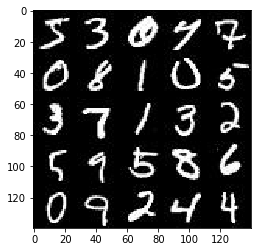

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

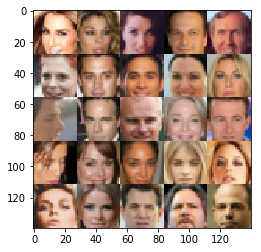

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 28x28x1 or 28x28x3
        # for leaky ReLU
        alpha = 0.2
        
        # make 14x14x64
        filters = 64
        x1 = tf.layers.conv2d(inputs=images, filters=filters, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filters, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filters, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattend_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattend_layer, units=1, activation=None, use_bias=True)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False if is_train == True else True
    with tf.variable_scope('generator', reuse=reuse):
        # input is z_dim
        
        # for leaky ReLU
        alpha = 0.2
        
        # 1. Fully connected layer (make 3x3x512) & reshape to prepare first layer
        feature_map_size = 512
        x1 = tf.layers.dense(inputs=z, units=3*3*feature_map_size, activation=None, use_bias=True)
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. deconvolutional layer (make 7x7x256)
        # kernel size & padding should be 3 & 'valid' to make output layer it 7x7x256
        # this is neccessary to make final layer 28x28x?
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. deconvolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4. Output layer, 28x28x1 or 28x28x1
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # build each model
    g_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # loss compuation graph
    smooth = 0.0
    d_real_label = tf.ones_like(d_logits_real) * (1 - smooth)
    d_fake_label = tf.zeros_like(d_logits_real)
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_label) )
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_label) )
    d_loss = d_loss_real + d_loss_fake
    
    g_label = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_label) )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get each trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimaization graph
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data ==> [number_of_images, width, height, channel]
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    # get input place holders
    input_real, input_z, input_learning_rate = model_inputs(image_width=data_shape[1], 
                                                            image_height=data_shape[2], 
                                                            image_channels=data_shape[3], 
                                                            z_dim=z_dim)
    
    # build model
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])
    
    # build optimizer
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=input_learning_rate, beta1=beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:        
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 0.0929... Generator Loss: 3.0361
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 10.3398
Epoch 1/2... Discriminator Loss: 2.8617... Generator Loss: 0.1300
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 3.3855
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 1.8606
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.3908
Epoch 1/2... Discriminator Loss: 0.3533... Generator Loss: 1.9450
Epoch 1/2... Discriminator Loss: 0.2974... Generator Loss: 2.4088


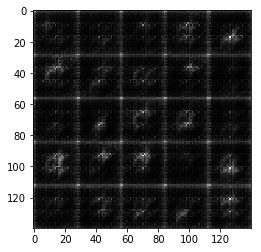

Epoch 1/2... Discriminator Loss: 0.3321... Generator Loss: 2.2142
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 3.4180
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 2.2782
Epoch 1/2... Discriminator Loss: 0.2847... Generator Loss: 2.2245
Epoch 1/2... Discriminator Loss: 0.3060... Generator Loss: 1.9542
Epoch 1/2... Discriminator Loss: 0.2439... Generator Loss: 2.1916
Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 2.2486
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 11.1954
Epoch 1/2... Discriminator Loss: 0.1555... Generator Loss: 3.0205
Epoch 1/2... Discriminator Loss: 0.1138... Generator Loss: 3.0943


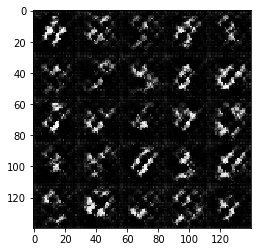

Epoch 1/2... Discriminator Loss: 0.1764... Generator Loss: 3.0417
Epoch 1/2... Discriminator Loss: 0.1997... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 0.1030... Generator Loss: 3.1163
Epoch 1/2... Discriminator Loss: 0.1677... Generator Loss: 2.2817
Epoch 1/2... Discriminator Loss: 0.1617... Generator Loss: 2.2053
Epoch 1/2... Discriminator Loss: 0.2776... Generator Loss: 4.6985
Epoch 1/2... Discriminator Loss: 0.4191... Generator Loss: 2.9601
Epoch 1/2... Discriminator Loss: 0.2222... Generator Loss: 4.3098
Epoch 1/2... Discriminator Loss: 2.1077... Generator Loss: 4.6020
Epoch 1/2... Discriminator Loss: 0.1770... Generator Loss: 3.5639


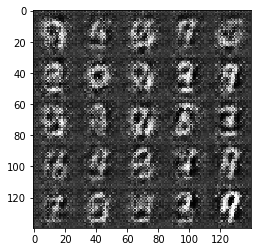

Epoch 1/2... Discriminator Loss: 1.5135... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 1.3876
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 1.7551
Epoch 1/2... Discriminator Loss: 0.2687... Generator Loss: 3.5278
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 0.4232... Generator Loss: 2.6949
Epoch 1/2... Discriminator Loss: 0.2828... Generator Loss: 2.7296
Epoch 1/2... Discriminator Loss: 0.5357... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 1.4945


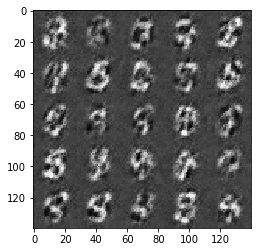

Epoch 1/2... Discriminator Loss: 0.2347... Generator Loss: 2.4254
Epoch 1/2... Discriminator Loss: 0.3049... Generator Loss: 2.0368
Epoch 1/2... Discriminator Loss: 0.2965... Generator Loss: 2.3812
Epoch 1/2... Discriminator Loss: 0.2425... Generator Loss: 2.0383
Epoch 1/2... Discriminator Loss: 0.1842... Generator Loss: 2.5795
Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 0.3285... Generator Loss: 1.7432
Epoch 1/2... Discriminator Loss: 0.1537... Generator Loss: 2.6091
Epoch 1/2... Discriminator Loss: 0.2899... Generator Loss: 2.8140
Epoch 1/2... Discriminator Loss: 0.2052... Generator Loss: 2.3045


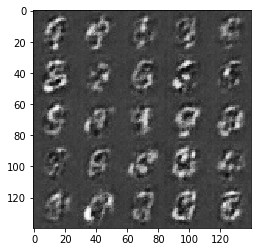

Epoch 1/2... Discriminator Loss: 0.3209... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 5.2348
Epoch 1/2... Discriminator Loss: 0.2823... Generator Loss: 3.0669
Epoch 1/2... Discriminator Loss: 0.1458... Generator Loss: 2.7288
Epoch 1/2... Discriminator Loss: 0.2139... Generator Loss: 2.1824
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.3993
Epoch 1/2... Discriminator Loss: 0.2679... Generator Loss: 2.0427
Epoch 1/2... Discriminator Loss: 0.1359... Generator Loss: 2.8663
Epoch 1/2... Discriminator Loss: 0.1573... Generator Loss: 2.7562


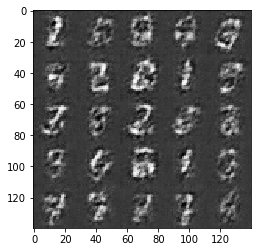

Epoch 1/2... Discriminator Loss: 0.3029... Generator Loss: 1.7846
Epoch 1/2... Discriminator Loss: 0.1609... Generator Loss: 3.7809
Epoch 1/2... Discriminator Loss: 0.2338... Generator Loss: 2.0767
Epoch 1/2... Discriminator Loss: 0.1384... Generator Loss: 3.0002
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 5.5499
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.3926
Epoch 1/2... Discriminator Loss: 0.2216... Generator Loss: 2.2233
Epoch 1/2... Discriminator Loss: 0.2272... Generator Loss: 2.1118
Epoch 1/2... Discriminator Loss: 0.1429... Generator Loss: 3.0291
Epoch 1/2... Discriminator Loss: 0.1289... Generator Loss: 2.7959


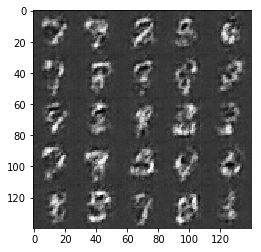

Epoch 1/2... Discriminator Loss: 0.2026... Generator Loss: 2.8932
Epoch 1/2... Discriminator Loss: 0.1181... Generator Loss: 2.8102
Epoch 1/2... Discriminator Loss: 0.1043... Generator Loss: 2.7846
Epoch 1/2... Discriminator Loss: 0.1492... Generator Loss: 2.4088
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 3.0271
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 1.6559
Epoch 1/2... Discriminator Loss: 0.2378... Generator Loss: 2.0586
Epoch 1/2... Discriminator Loss: 0.2446... Generator Loss: 1.9257


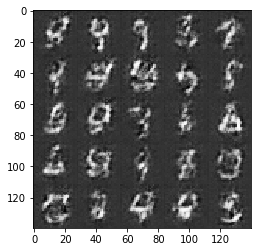

Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.4327
Epoch 1/2... Discriminator Loss: 0.1617... Generator Loss: 2.4755
Epoch 1/2... Discriminator Loss: 0.1202... Generator Loss: 2.6769
Epoch 1/2... Discriminator Loss: 0.1292... Generator Loss: 2.5971
Epoch 1/2... Discriminator Loss: 0.0888... Generator Loss: 3.5431
Epoch 1/2... Discriminator Loss: 0.1405... Generator Loss: 3.7882
Epoch 1/2... Discriminator Loss: 0.1404... Generator Loss: 2.8033
Epoch 1/2... Discriminator Loss: 0.1343... Generator Loss: 2.5188
Epoch 1/2... Discriminator Loss: 0.1599... Generator Loss: 2.9752
Epoch 1/2... Discriminator Loss: 0.1178... Generator Loss: 2.8651


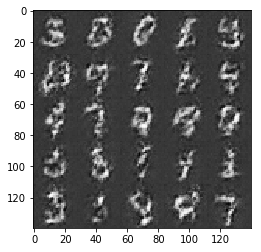

Epoch 1/2... Discriminator Loss: 0.1209... Generator Loss: 2.7599
Epoch 1/2... Discriminator Loss: 0.0804... Generator Loss: 3.0243
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.4640
Epoch 2/2... Discriminator Loss: 0.0575... Generator Loss: 3.7057
Epoch 2/2... Discriminator Loss: 0.1043... Generator Loss: 2.7046
Epoch 2/2... Discriminator Loss: 0.0688... Generator Loss: 3.3972
Epoch 2/2... Discriminator Loss: 0.1385... Generator Loss: 2.5090
Epoch 2/2... Discriminator Loss: 0.1005... Generator Loss: 2.8974
Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 2.7486
Epoch 2/2... Discriminator Loss: 0.1316... Generator Loss: 2.5778


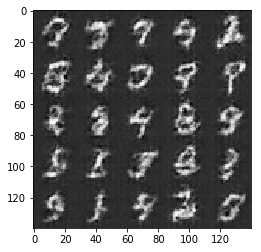

Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 3.0810
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 2.9577
Epoch 2/2... Discriminator Loss: 0.1201... Generator Loss: 2.7710
Epoch 2/2... Discriminator Loss: 0.1245... Generator Loss: 2.9995
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 2.0664
Epoch 2/2... Discriminator Loss: 0.2526... Generator Loss: 2.1557
Epoch 2/2... Discriminator Loss: 0.1875... Generator Loss: 2.7101
Epoch 2/2... Discriminator Loss: 0.2055... Generator Loss: 2.0981
Epoch 2/2... Discriminator Loss: 0.1845... Generator Loss: 2.2396
Epoch 2/2... Discriminator Loss: 0.1488... Generator Loss: 2.7608


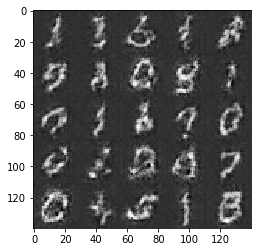

Epoch 2/2... Discriminator Loss: 0.1351... Generator Loss: 2.4000
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 2.6475
Epoch 2/2... Discriminator Loss: 0.1010... Generator Loss: 3.1233
Epoch 2/2... Discriminator Loss: 0.1032... Generator Loss: 2.8705
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 2.7111
Epoch 2/2... Discriminator Loss: 0.1990... Generator Loss: 2.1185
Epoch 2/2... Discriminator Loss: 0.1275... Generator Loss: 2.4640
Epoch 2/2... Discriminator Loss: 0.1242... Generator Loss: 2.7345
Epoch 2/2... Discriminator Loss: 0.1055... Generator Loss: 2.7591
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 3.9900


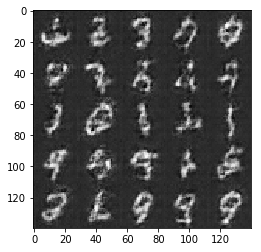

Epoch 2/2... Discriminator Loss: 0.0942... Generator Loss: 2.8992
Epoch 2/2... Discriminator Loss: 0.0549... Generator Loss: 3.9411
Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 3.5532
Epoch 2/2... Discriminator Loss: 0.1169... Generator Loss: 2.6599
Epoch 2/2... Discriminator Loss: 0.1145... Generator Loss: 3.7619
Epoch 2/2... Discriminator Loss: 0.0803... Generator Loss: 4.5786
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.4097
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 2.9064
Epoch 2/2... Discriminator Loss: 0.2933... Generator Loss: 1.9656


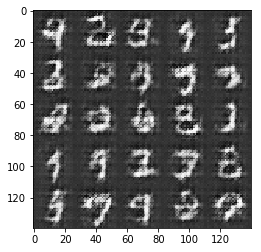

Epoch 2/2... Discriminator Loss: 0.1699... Generator Loss: 2.4928
Epoch 2/2... Discriminator Loss: 1.7633... Generator Loss: 5.7011
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 0.1315... Generator Loss: 3.5024
Epoch 2/2... Discriminator Loss: 0.1924... Generator Loss: 2.1923
Epoch 2/2... Discriminator Loss: 0.1218... Generator Loss: 2.7880
Epoch 2/2... Discriminator Loss: 0.0938... Generator Loss: 2.9441
Epoch 2/2... Discriminator Loss: 0.0713... Generator Loss: 3.7064
Epoch 2/2... Discriminator Loss: 0.1295... Generator Loss: 2.6102
Epoch 2/2... Discriminator Loss: 0.2945... Generator Loss: 1.6214


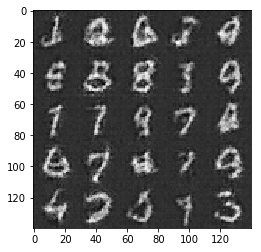

Epoch 2/2... Discriminator Loss: 0.1773... Generator Loss: 2.1380
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 2.2416
Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 4.1807
Epoch 2/2... Discriminator Loss: 0.0494... Generator Loss: 3.7500
Epoch 2/2... Discriminator Loss: 0.1098... Generator Loss: 2.7649
Epoch 2/2... Discriminator Loss: 0.0549... Generator Loss: 3.4336
Epoch 2/2... Discriminator Loss: 0.0509... Generator Loss: 4.1890
Epoch 2/2... Discriminator Loss: 0.1004... Generator Loss: 2.8270
Epoch 2/2... Discriminator Loss: 0.0911... Generator Loss: 2.9101
Epoch 2/2... Discriminator Loss: 0.0465... Generator Loss: 3.7732


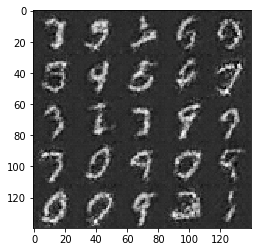

Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 3.1602
Epoch 2/2... Discriminator Loss: 0.0442... Generator Loss: 4.1780
Epoch 2/2... Discriminator Loss: 0.0564... Generator Loss: 3.5409
Epoch 2/2... Discriminator Loss: 0.0458... Generator Loss: 3.6005
Epoch 2/2... Discriminator Loss: 0.0497... Generator Loss: 3.9803
Epoch 2/2... Discriminator Loss: 0.0456... Generator Loss: 3.6643
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 4.9485
Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 2.5903
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 3.7255
Epoch 2/2... Discriminator Loss: 0.3007... Generator Loss: 5.6860


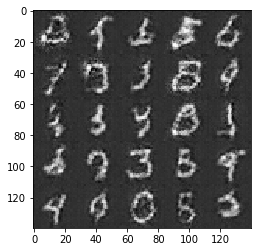

Epoch 2/2... Discriminator Loss: 0.1097... Generator Loss: 2.7722
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.7864
Epoch 2/2... Discriminator Loss: 0.0631... Generator Loss: 3.2888
Epoch 2/2... Discriminator Loss: 0.1122... Generator Loss: 2.5981
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 2.8930
Epoch 2/2... Discriminator Loss: 0.0245... Generator Loss: 4.5796
Epoch 2/2... Discriminator Loss: 0.0436... Generator Loss: 3.8046
Epoch 2/2... Discriminator Loss: 0.0480... Generator Loss: 3.7169
Epoch 2/2... Discriminator Loss: 0.0265... Generator Loss: 4.2854
Epoch 2/2... Discriminator Loss: 0.1496... Generator Loss: 2.3679


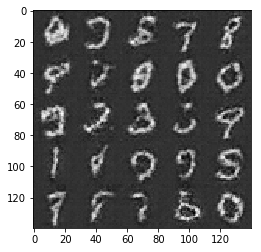

Epoch 2/2... Discriminator Loss: 0.0326... Generator Loss: 4.8601
Epoch 2/2... Discriminator Loss: 0.1274... Generator Loss: 2.4953
Epoch 2/2... Discriminator Loss: 0.0706... Generator Loss: 3.4796
Epoch 2/2... Discriminator Loss: 0.0369... Generator Loss: 5.5231
Epoch 2/2... Discriminator Loss: 0.0884... Generator Loss: 2.9218
Epoch 2/2... Discriminator Loss: 0.0384... Generator Loss: 4.0654
Epoch 2/2... Discriminator Loss: 0.0590... Generator Loss: 3.6817
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 0.8367


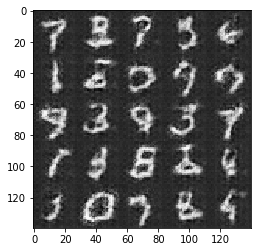

Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.7628
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 2.0642
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.2478


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.1768
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 5.0409
Epoch 1/1... Discriminator Loss: 3.5474... Generator Loss: 0.0639
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 2.9715
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.1652


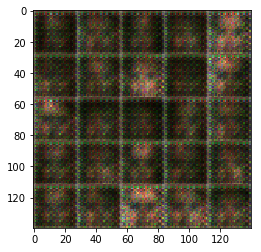

Epoch 1/1... Discriminator Loss: 0.2614... Generator Loss: 1.9114
Epoch 1/1... Discriminator Loss: 0.0923... Generator Loss: 3.2879
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 2.9673
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 4.5381
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 3.9379
Epoch 1/1... Discriminator Loss: 3.0778... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 4.0461... Generator Loss: 0.0638
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 0.2256... Generator Loss: 3.9693
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.6674


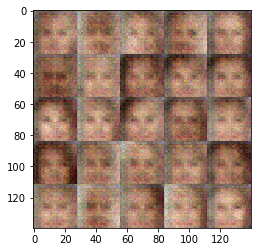

Epoch 1/1... Discriminator Loss: 0.2679... Generator Loss: 5.4664
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 4.9503
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 3.1421
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.0255
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 3.5941
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 0.2361... Generator Loss: 2.6277
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.2891


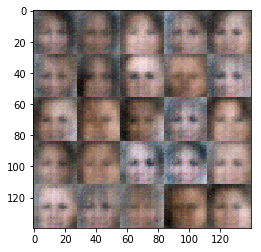

Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 5.6644
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 6.8661
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 0.2038... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 2.2492
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 4.1762


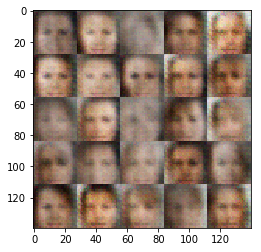

Epoch 1/1... Discriminator Loss: 0.1392... Generator Loss: 3.6012
Epoch 1/1... Discriminator Loss: 1.7597... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.2852
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.5584
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.0117
Epoch 1/1... Discriminator Loss: 0.0954... Generator Loss: 4.4381
Epoch 1/1... Discriminator Loss: 0.2591... Generator Loss: 5.4287
Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 4.2251
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.8087


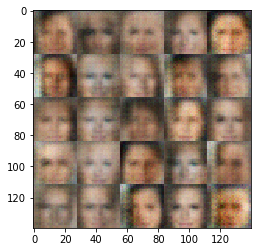

Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 2.5583
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 2.0262
Epoch 1/1... Discriminator Loss: 0.2513... Generator Loss: 2.7079
Epoch 1/1... Discriminator Loss: 0.0759... Generator Loss: 3.8258
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.6425
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.1526... Generator Loss: 6.1377
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.9145
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 3.7559
Epoch 1/1... Discriminator Loss: 0.2797... Generator Loss: 2.3592


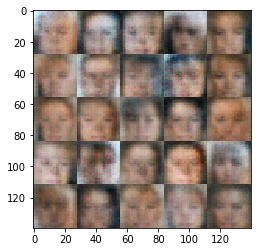

Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 4.5878
Epoch 1/1... Discriminator Loss: 0.1765... Generator Loss: 6.8861
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 9.4788
Epoch 1/1... Discriminator Loss: 0.1260... Generator Loss: 2.8716
Epoch 1/1... Discriminator Loss: 0.0774... Generator Loss: 5.0390
Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 8.0842
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 5.9889
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 7.0554
Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 8.4097
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 8.1905


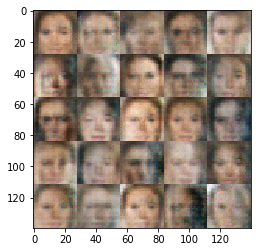

Epoch 1/1... Discriminator Loss: 0.0335... Generator Loss: 8.0089
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 8.4171
Epoch 1/1... Discriminator Loss: 1.9750... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 1.8284
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 9.6705
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.8936
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 6.0252
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 6.7057
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 4.2370
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 7.7002


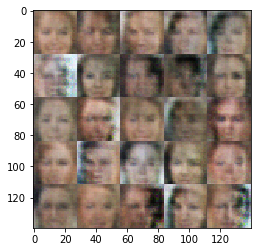

Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 4.3322
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 5.0049
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 6.6509
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 3.5569
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 5.0045
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 7.1216
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.7384


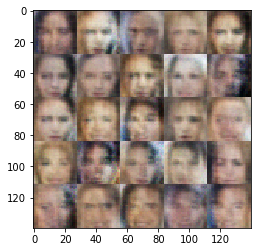

Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 9.8602
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 4.1592
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 3.8108
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 10.1850
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 9.9167
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 8.0107
Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 2.6692
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 2.9582


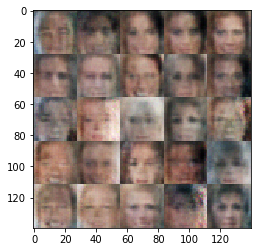

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 7.9129
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 3.2037
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 11.2557
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.7385
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 3.2707
Epoch 1/1... Discriminator Loss: 4.8613... Generator Loss: 10.4092
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 6.2231
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 9.7396
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 3.9118


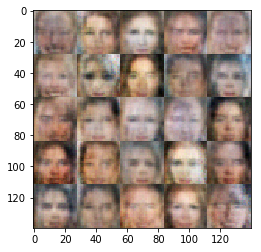

Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 10.4342
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 7.8986
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 7.4455
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 8.4005
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 10.8800
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 3.8633
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 8.6444
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.5041
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 9.0611


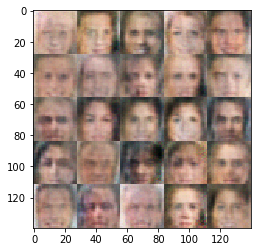

Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 2.6429
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 4.4089
Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 8.9772
Epoch 1/1... Discriminator Loss: 0.2229... Generator Loss: 2.6092
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 4.1166
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 5.6730
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 6.2413
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 8.9155
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 8.8154
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 2.8987


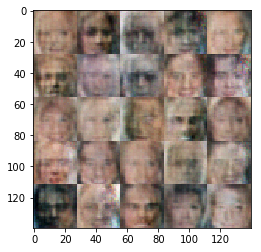

Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 7.2660
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 6.1265
Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 4.9892
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 7.9386
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.3157
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 7.1614
Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 8.5482
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 6.3580
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 3.2057


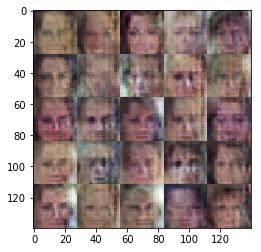

Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 8.0645
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 5.6535
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 8.3392
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 7.4274
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 8.9460
Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 1.9482
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 4.0376
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 0.9533


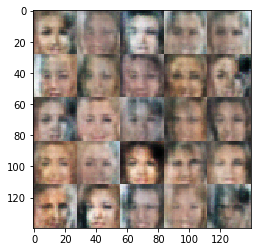

Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 2.0736
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 6.0839
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 7.2971
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.0068
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 5.9773
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 6.6316


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.